In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from IPython.display import display, Image, HTML

%matplotlib inline
TRAIN_DIR = '/Users/hehongwei/datas/Cat_Dog/train/'
TEST_DIR = '/Users/hehongwei/datas/Cat_Dog/test/'

In [9]:
IMAGE_SIZE = 150
CHANNELS = 3
pixel_depth = 255.0

OUTFILE = '/Users/hehongwei/Downloads/CatsAndDogs_pal15Jan2017_SmallerTest.npsave.bin'
TRAINING_AND_VALIDATION_SIZE_DOGS = 1000 
TRAINING_AND_VALIDATION_SIZE_CATS = 1000 
TRAINING_AND_VALIDATION_SIZE_ALL  = 2000
TRAINING_SIZE = 1600  # TRAINING_SIZE + VALID_SIZE must equal TRAINING_AND_VALIDATION_SIZE_ALL
VALID_SIZE = 400
TEST_SIZE_ALL = 500

if (TRAINING_SIZE + VALID_SIZE != TRAINING_AND_VALIDATION_SIZE_ALL):
    print ("Error, check that TRAINING_SIZE+VALID_SIZE is equal to TRAINING_AND_VALIDATION_SIZE_ALL")
    exit ()
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)][1:]
train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)][1:]

train_images = train_dogs[:TRAINING_AND_VALIDATION_SIZE_DOGS] + train_cats[:TRAINING_AND_VALIDATION_SIZE_CATS]
train_labels = np.array ((['dogs'] * TRAINING_AND_VALIDATION_SIZE_DOGS) + (['cats'] * TRAINING_AND_VALIDATION_SIZE_CATS))

test_images = test_images[:TEST_SIZE_ALL]
test_labels = np.array (['unknownclass'] * TEST_SIZE_ALL)

In [10]:
# resizes to IMAGE_SIZE/IMAGE_SIZE while keeping aspect ratio the same.  pads on right/bottom as appropriate 
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    if (img.shape[0] >= img.shape[1]): # height is greater than width
       resizeto = (IMAGE_SIZE, int (round (IMAGE_SIZE * (float (img.shape[1])  / img.shape[0]))));
    else:
       resizeto = (int (round (IMAGE_SIZE * (float (img.shape[0])  / img.shape[1]))), IMAGE_SIZE);
    
    img2 = cv2.resize(img, (resizeto[1], resizeto[0]), interpolation=cv2.INTER_CUBIC)
    img3 = cv2.copyMakeBorder(img2, 0, IMAGE_SIZE - img2.shape[0], 0, IMAGE_SIZE - img2.shape[1], cv2.BORDER_CONSTANT, 0)
        
    return img3[:,:,::-1]  # turn into rgb format

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)

    for i, image_file in enumerate(images):
        image = read_image(image_file);
        image_data = np.array (image, dtype=np.float32);
        # 归一化
        image_data[:,:,0] = (image_data[:,:,0].astype(float) - pixel_depth / 2) / pixel_depth
        image_data[:,:,1] = (image_data[:,:,1].astype(float) - pixel_depth / 2) / pixel_depth
        image_data[:,:,2] = (image_data[:,:,2].astype(float) - pixel_depth / 2) / pixel_depth
        
        data[i] = image_data; # image_data.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))    
    return data

train_normalized = prep_data(train_images)
test_normalized = prep_data(test_images)

print("Train shape: {}".format(train_normalized.shape))
print("Test shape: {}".format(test_normalized.shape))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 500
Processed 250 of 500
Train shape: (2000, 150, 150, 3)
Test shape: (500, 150, 150, 3)


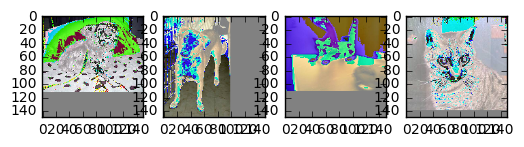

In [13]:
plt.subplot(1,4,1)
plt.imshow(train_normalized[0])
plt.subplot(1,4,2)
plt.imshow(train_normalized[1])
plt.subplot(1,4,3)
plt.imshow(train_normalized[1000])
plt.subplot(1,4,4)
plt.imshow(train_normalized[1001])
plt.show()

洗牌，然后将训练集切分为训练集和交叉验证集

In [20]:
np.random.seed (133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset_rand, train_labels_rand = randomize(train_normalized, train_labels)
test_dataset, test_labels = randomize(test_normalized, test_labels)

# split up into training + valid
valid_dataset = train_dataset_rand[:VALID_SIZE,:,:,:]
valid_labels =   train_labels_rand[:VALID_SIZE]
train_dataset = train_dataset_rand[VALID_SIZE:VALID_SIZE+TRAINING_SIZE,:,:,:]
train_labels  = train_labels_rand[VALID_SIZE:VALID_SIZE+TRAINING_SIZE]
print ('Training', train_dataset.shape, train_labels.shape)
print ('Validation', valid_dataset.shape, valid_labels.shape)
print ('Test', test_dataset.shape, test_labels.shape)

('Training', (1600, 150, 150, 3), (1600,))
('Validation', (400, 150, 150, 3), (400,))
('Test', (500, 150, 150, 3), (500,))


In [32]:
import tensorflow as tf
image_size = IMAGE_SIZE
num_labels = 2
num_channels = 3

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (labels=='cats').astype(np.float32); # set dogs to 0 and cats to 1
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print ('Training set', train_dataset.shape, train_labels.shape)
print ('Validation set', valid_dataset.shape, valid_labels.shape)
print ('Test set', test_dataset.shape, test_labels.shape)

('Training set', (1600, 150, 150, 3), (1600, 2))
('Validation set', (400, 150, 150, 3), (400, 2))
('Test set', (500, 150, 150, 3), (500, 2))


定义卷积网络

In [40]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # variables 
  kernel_conv1 = tf.Variable(tf.truncated_normal([3, 3, 3, 32], dtype=tf.float32,
                                            stddev=1e-1), name='weights_conv1')
  biases_conv1 = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                        trainable=True, name='biases_conv1')
  kernel_conv2 = tf.Variable(tf.truncated_normal([3, 3, 32, 32], dtype=tf.float32,
                                            stddev=1e-1), name='weights_conv2')
  biases_conv2 = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                        trainable=True, name='biases_conv2')
  kernel_conv3 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], dtype=tf.float32,
                                            stddev=1e-1), name='weights_conv3')
  biases_conv3 = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                        trainable=True, name='biases_conv3')
  fc1w = tf.Variable(tf.truncated_normal([23104, 64], 
                                                dtype=tf.float32,
                                                stddev=1e-1), name='weights') # 23104 from pool3.gete_shape () of 19*19*64
  fc1b = tf.Variable(tf.constant(1.0, shape=[64], dtype=tf.float32),
                        trainable=True, name='biases')
  fc2w = tf.Variable(tf.truncated_normal([64, 2],
                                                dtype=tf.float32,
                                                stddev=1e-1), name='weights')
  fc2b = tf.Variable(tf.constant(1.0, shape=[2], dtype=tf.float32),
                        trainable=True, name='biases')
 
  
  def model(data):
     parameters = []
     with tf.name_scope('conv1_1') as scope:
         conv = tf.nn.conv2d(data, kernel_conv1, [1, 1, 1, 1], padding='SAME')
         out = tf.nn.bias_add(conv, biases_conv1)
         conv1_1 = tf.nn.relu(out, name=scope)
         parameters += [kernel_conv1, biases_conv1]
         
     # pool1
     pool1 = tf.nn.max_pool(conv1_1,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME',
                            name='pool1')
     
     with tf.name_scope('conv2_1') as scope:
         conv = tf.nn.conv2d(pool1, kernel_conv2, [1, 1, 1, 1], padding='SAME')
         out = tf.nn.bias_add(conv, biases_conv2)
         conv2_1 = tf.nn.relu(out, name=scope)
         parameters += [kernel_conv2, biases_conv2]
         
     # pool2
     pool2 = tf.nn.max_pool(conv2_1,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME',
                            name='pool2')
     
     with tf.name_scope('conv3_1') as scope:
         conv = tf.nn.conv2d(pool2, kernel_conv3, [1, 1, 1, 1], padding='SAME')
         out = tf.nn.bias_add(conv, biases_conv3)
         conv3_1 = tf.nn.relu(out, name=scope)
         parameters += [kernel_conv3, biases_conv3]
         
     # pool3
     pool3 = tf.nn.max_pool(conv3_1,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME',
                            name='pool3')
         
     # fc1
     with tf.name_scope('fc1') as scope:
         shape = int(np.prod(pool3.get_shape()[1:])) # except for batch size (the first one), multiple the dimensions
         pool3_flat = tf.reshape(pool3, [-1, shape])
         fc1l = tf.nn.bias_add(tf.matmul(pool3_flat, fc1w), fc1b)
         fc1 = tf.nn.relu(fc1l)
         parameters += [fc1w, fc1b]

     # fc3
     with tf.name_scope('fc3') as scope:
         fc2l = tf.nn.bias_add(tf.matmul(fc1, fc2w), fc2b)
         parameters += [fc2w, fc2b]
     return fc2l;
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [47]:
def accuracy(predictions, labels):
    return 100.0*np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0]

num_steps = 1001
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print 'Initializes'
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset: (offset + batch_size), :, :, :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print ("Minibatch loss at step", step, ":", l)
            print ("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print ("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

Initializes
('Minibatch loss at step', 0, ':', 1.4229143)
Minibatch accuracy: 56.2%
Validation accuracy: 51.2%
('Minibatch loss at step', 50, ':', 0.97912753)
Minibatch accuracy: 31.2%
Validation accuracy: 48.2%
('Minibatch loss at step', 100, ':', 0.7673713)
Minibatch accuracy: 50.0%
Validation accuracy: 52.2%
('Minibatch loss at step', 150, ':', 0.8138718)
Minibatch accuracy: 37.5%
Validation accuracy: 54.0%
('Minibatch loss at step', 200, ':', 0.7270565)
Minibatch accuracy: 56.2%
Validation accuracy: 52.8%
('Minibatch loss at step', 250, ':', 0.66731244)
Minibatch accuracy: 75.0%
Validation accuracy: 58.0%
('Minibatch loss at step', 300, ':', 0.67924899)
Minibatch accuracy: 50.0%
Validation accuracy: 60.5%
('Minibatch loss at step', 350, ':', 0.48868722)
Minibatch accuracy: 81.2%
Validation accuracy: 60.8%
('Minibatch loss at step', 400, ':', 0.53116435)
Minibatch accuracy: 68.8%
Validation accuracy: 62.5%
('Minibatch loss at step', 450, ':', 0.68452847)
Minibatch accuracy: 56.2%
Va

定义第一层卷积

定义第二层卷积

定义第三层卷积